<a href="https://colab.research.google.com/github/alammobaDar/CCADMACL_PROJECT_COM231ML/blob/main/CLUSTERING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Dependencies

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

## Load Dataset

In [ ]:
drive.mount("/content/drive")

path = "/content/drive/My Drive/Datasets/flows_sampled_2000(1).csv"

df = pd.read_csv(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df.head()

,packet_count,byte_count,avg_pkt_len,std_pkt_len,start_time,end_time,avg_iat,std_iat,flow_duration,ip_src,ip_dst,src_port,dst_port,ip_proto
0,6,344.0,57.333333,8.164966,1.744194e+09,1.744194e+09,1.494267,1.041341,7.471334,167.89.182.126,202.24.165.141,45746.0,53609.0,6.0
1,6,612.0,102.000000,100.901933,1.744194e+09,1.744194e+09,3.715824,8.282814,18.579121,163.164.144.165,104.45.240.24,64712.0,443.0,6.0
2,11,8787.0,798.818182,1320.119905,1.744194e+09,1.744194e+09,0.189680,0.311778,1.896796,161.117.139.230,150.67.110.222,443.0,48946.0,6.0
3,5,391.0,78.200000,23.069460,1.744194e+09,1.744194e+09,0.119083,0.137180,0.476333,51.217.99.57,203.178.181.27,52624.0,53.0,6.0
4,10,1937.0,193.700000,257.784169,1.744194e+09,1.744194e+09,0.339914,0.263165,3.059223,133.28.231.176,91.249.139.99,3389.0,15327.0,6.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   packet_count   2000 non-null   int64  
 1   byte_count     2000 non-null   float64
 2   avg_pkt_len    2000 non-null   float64
 3   std_pkt_len    2000 non-null   float64
 4   start_time     2000 non-null   float64
 5   end_time       2000 non-null   float64
 6   avg_iat        2000 non-null   float64
 7   std_iat        2000 non-null   float64
 8   flow_duration  2000 non-null   float64
 9   ip_src         2000 non-null   object 
 10  ip_dst         2000 non-null   object 
 11  src_port       2000 non-null   float64
 12  dst_port       2000 non-null   float64
 13  ip_proto       2000 non-null   float64
dtypes: float64(11), int64(1), object(2)
memory usage: 218.9+ KB


In [ ]:
df.describe()

,packet_count,byte_count,avg_pkt_len,std_pkt_len,start_time,end_time,avg_iat,std_iat,flow_duration,src_port,dst_port,ip_proto
count,2000.000000,2.000000e+03,2000.000000,2000.000000,2.000000e+03,2.000000e+03,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,37.075000,2.148685e+04,271.333409,246.971990,1.744194e+09,1.744194e+09,1.620718,1.817643,18.019611,27967.226500,25252.236000,11.500000
std,133.743434,2.800133e+05,442.112937,433.017930,1.928422e+01,1.834439e+01,2.694333,3.160359,22.154922,24969.878876,25456.453317,5.501376
min,5.000000,2.700000e+02,54.000000,0.000000,1.744194e+09,1.744194e+09,0.000005,0.000009,0.000036,22.000000,3.000000,6.000000
25%,7.000000,7.040000e+02,87.095455,5.877441,1.744194e+09,1.744194e+09,0.026292,0.022108,0.236664,443.000000,443.000000,6.000000
50%,10.000000,1.940500e+03,138.000000,107.715307,1.744194e+09,1.744194e+09,0.309377,0.317093,6.025172,27776.000000,12254.500000,11.500000
75%,18.000000,6.272500e+03,303.291176,402.750105,1.744194e+09,1.744194e+09,1.818539,2.308442,35.274692,53365.750000,52816.750000,17.000000
max,1925.000000,7.840028e+06,9881.685121,6498.536685,1.744194e+09,1.744194e+09,15.015378,24.252239,62.461515,65515.000000,65527.000000,17.000000


In [ ]:
df.isna().sum()

,0
packet_count,0
byte_count,0
avg_pkt_len,0
std_pkt_len,0
start_time,0
end_time,0
avg_iat,0
std_iat,0
flow_duration,0
ip_src,0


In [ ]:
# Remove object types

X = df.drop(["ip_src", "ip_dst"], axis=1)

## Initial visualisation of the dataset

<Axes: >

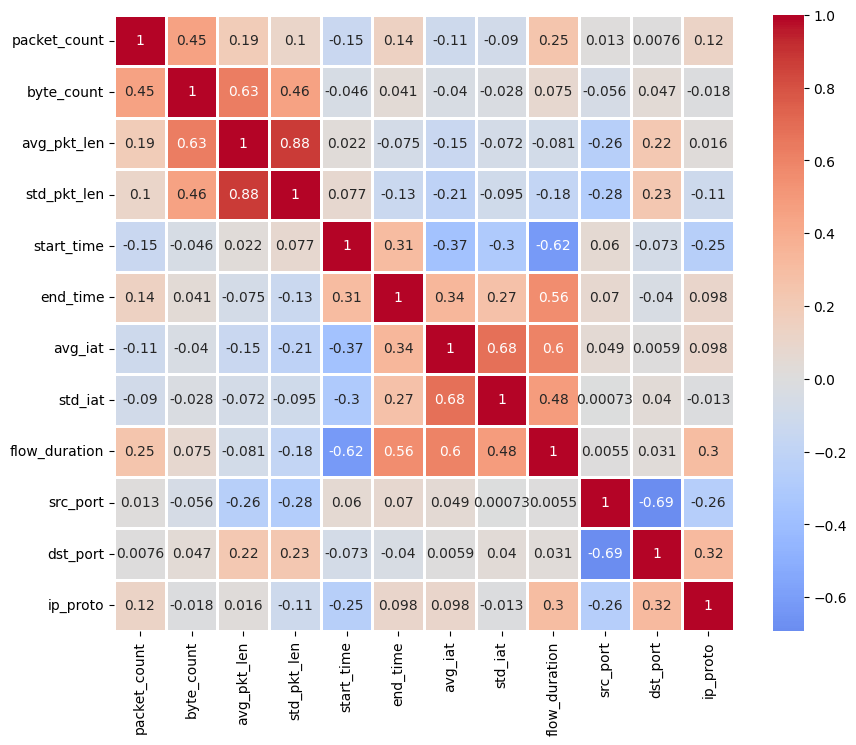

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(X.corr(), cmap="coolwarm", center=0, annot=True, linewidths=2)

In [ ]:
sns.pairplot(df)

## Scale Data

### Standard Scaler

In [ ]:
sscaler = StandardScaler()
X_sscaled = sscaler.fit_transform(X)

X_sscaled = pd.DataFrame(X_sscaled, columns=X.columns)

In [ ]:
X_sscaled.head()

### Robust Scaler

In [ ]:
rscaler = RobustScaler()
X_rscaled = rscaler.fit_transform(X)

X_rscaled = pd.DataFrame(X_rscaled, columns=X.columns)

In [ ]:
X_rscaled.head()

# PCA IMPLEMENTATION

In [ ]:
def reduce_dimensions(X, n_components, is2_dim=True):
    pca = PCA(n_components=n_components)
    X_reduced = pca.fit_transform(X)

    print("Number of components kept:", pca.n_components_)
    print("Explained variance ratio:", pca.explained_variance_ratio_)
    print("Total variance retained:", sum(pca.explained_variance_ratio_))

    if is2_dim:
      loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
      loading_matrix = pd.DataFrame(loadings, columns=['PC1', 'PC2'], index=X.columns)
      print(loading_matrix)

    else:
      loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
      loading_matrix = pd.DataFrame(loadings, columns=[f"PC{i}" for i in range(pca.n_components_)], index=X.columns)
      print(loading_matrix)

    return X_reduced

def visualize_reduced_data(X, X_reduced):
    plt.figure(figsize=(10, 8))
    sns.heatmap(X.corr(), annot=True, cmap="coolwarm")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

    ax1.boxplot(X)
    ax1.set_title("Box Plot of scaled data")
    ax1.set_xlabel("Features")
    ax1.set_ylabel("Values")

    ax2.scatter(X_reduced[:,0], X_reduced[:,1])
    ax2.set_title("Scatter plot of reduced data")
    ax2.set_xlabel("PC1")
    ax2.set_ylabel("PC2")

    plt.show()

## PCA (Standard Scaler)

In [ ]:
X_sscaled_reduced= reduce_dimensions(X_sscaled, 2)

In [ ]:
visualize_reduced_data(X_sscaled, X_sscaled_reduced)

## PCA (Robust Scaler)

In [ ]:
X_rscaled_reduced = reduce_dimensions(X_rscaled, 2)

In [ ]:
visualize_reduced_data(X_rscaled, X_rscaled_reduced)

***Based on the results of base PCA with Standard / Robust Scaler is not reliable for our datasets we are going to try to work around with PCA***

## PCA Workaround

In [ ]:
# Log Transform

x_log = np.log1p(X)
x_log = pd.DataFrame(x_log, columns=X.columns)

x_log_sscaled = sscaler.fit_transform(x_log)
x_log_sscaled = pd.DataFrame(x_log_sscaled, columns=X.columns)
x_log_sscaled_reduced = reduce_dimensions(x_log_sscaled, 0.9, is2_dim=False)

visualize_reduced_data(x_log, x_log_sscaled_reduced)

x_log_rscaled = rscaler.fit_transform(x_log)
x_log_rscaled = pd.DataFrame(x_log_rscaled, columns=X.columns)
x_log_rscaled_reduced = reduce_dimensions(x_log_rscaled, 0.9, is2_dim=False)

visualize_reduced_data(x_log, x_log_rscaled_reduced)

 ***We are going to use Robust Scaler here since it has better spread than Standard Scaler***

In [ ]:
wcss = []
sse = {}
for i in range(1, 11):
    kmeans =  KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(x_log_rscaled_reduced)

    wcss.append(kmeans.inertia_)
    sse[i] = kmeans.inertia_
    print(f"For cluster = {i}, SSE/WCSS is {sse[i]}")

plt.plot(range(1, 11), wcss)
plt.title("Elbow method")
plt.xlabel("Number of cluster")
plt.ylabel("WCSS")
plt.show()



In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)
clusters = kmeans.fit_predict(x_log_rscaled_reduced)


In [ ]:

plt.figure(figsize=(10, 6))
sns.scatterplot(x=x_log_rscaled_reduced[:, 0], y=x_log_rscaled_reduced[:, 1], hue=clusters, palette='viridis')
plt.title("K-Means Clusters on PCA Space")
plt.show()



# UMAP Implementation

In [ ]:
import umap

X_umap = umap.UMAP(
    n_neighbors=30,
    min_dist=0.05,
    n_components=2,
    random_state=42,
    n_jobs=1
).fit_transform(X_sscaled_reduced)



In [ ]:
states = list(range(0, 42, 4))

def test_umap_consistency(states):
  for state in states:
    X_umap = umap.UMAP(
      n_neighbors=30,
      min_dist=0.05,
      n_components=2,
      random_state=state,
      n_jobs=1
    ).fit_transform(X_sscaled_reduced)

    sns.scatterplot(x=X_umap[:,0], y=X_umap[:,1], s=10)
    plt.title(f"State: {state}")
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.show()

test_umap_consistency(states)

In [ ]:
from sklearn.manifold import trustworthiness

score = trustworthiness(X_sscaled_reduced, X_umap, n_neighbors=30)
print(score)

In [ ]:

umap_df = pd.DataFrame(X_umap, columns=['UMAP1', 'UMAP2'])

corr = pd.concat([X, umap_df], axis=1).corr()
corr.loc[X.columns, ['UMAP1', 'UMAP2']]

In [ ]:
sns.scatterplot(x=umap_df['UMAP1'], y=umap_df['UMAP2'], hue=X['flow_duration'], palette='viridis')
plt.title("UMAP Colored by Flow Duration")
plt.show()

### Lets try to use DBSCAN and HDBSCAN

In [ ]:
from hdbscan import HDBSCAN
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

hdb = HDBSCAN()

hdb_clusters = hdb.fit_predict(x_log_rscaled_reduced)


### DBSCAN

In [ ]:
nn = NearestNeighbors(n_neighbors=4)
nn.fit(umap_df)
distances, indices = nn.kneighbors(umap_df)

distab = np.sort(distances, axis=0)
distab = distab[:, 3]
plt.figure(figsize=(10,8))
plt.plot(distab)

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(distab)
plt.axhline(y=0.3, color='r', linestyle='--') # Example: if the elbow is at 0.3
plt.title("K-Distance Plot (k=4)")
plt.ylabel("Distance to 4th Neighbor (eps)")
plt.xlabel("Points sorted by distance")
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
x = np.arange(len(distab))
y = distab

x1, y1 = x[0], y[0]
x2, y2 = x[-1], y[-1]

numerator = np.abs((y2 - y1) * x - (x2 - x1) * y + x2*y1 - y2*x1)
denominator = np.sqrt((y2 - y1)**2 + (x2 - x1)**2)

distances_to_line = numerator / denominator

elbow_idx = np.argmax(distances_to_line)
elbow_value = y[elbow_idx]

print("Optimal eps:", elbow_value)

In [ ]:
min_samples=range(1,15)
ep = 0.6
for min_sample in min_samples:
    db = DBSCAN(eps=ep, min_samples=min_sample, metric="euclidean")
    db.fit(umap_df)
    labels = db.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    print(f"min_samples={min_sample}: clusters={n_clusters}")



In [ ]:
db = DBSCAN(eps=0.6, min_samples=5, metric="euclidean")
db.fit(umap_df)
labels = db.labels_
n_noise = list(labels).count(-1)
print(f"noise points={n_noise}")



In [ ]:


umap_df['cluster'] = db.labels_



In [ ]:
umap_df.head()


In [ ]:
# 1. Add the labels to your UMAP DataFrame

# 2. Create a color palette where noise (-1) is black/gray
unique_labels = sorted(umap_df['cluster'].unique())
# Use a bright palette for clusters
colors = sns.color_palette("viridis", len(unique_labels))
color_dict = {label: colors[i] for i, label in enumerate(unique_labels)}

# 3. Plotting
plt.figure(figsize=(10, 8))

# Use different markers for noise vs clusters for even better clarity
sns.scatterplot(
    x=umap_df['UMAP1'],
    y=umap_df['UMAP2'],
    hue=umap_df['Cluster'],
    palette=color_dict,
    style=(umap_df['Cluster'] == -1), # X for noise, O for clusters
    markers={True: 'X', False: 'o'},
    alpha=0.7,
    s=30
)

plt.title(f"DBSCAN Clusters on UMAP Projection\n(eps={0.6}, min_samples={5})")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")

# Move legend outside the plot
plt.legend(title='Cluster ID\n(-1 = Noise)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()